In [2]:
import os
import ember
import lightgbm as lgb
import shap
import numpy as np
import pandas as pd

binary_name = "mimikatz.exe" #set this to the binary name, put the ones u want to test in /binaries

data_dir = "../ember2018/"

In [3]:
# ~4 mns
binary_location = f"/workspaces/torment-nexus/binaries/{binary_name}"

emberdf = ember.read_metadata(data_dir)
X_train, y_train, X_test, y_test = ember.read_vectorized_features(data_dir, feature_version=2)
lgbm_model = lgb.Booster(model_file=os.path.join(data_dir, "ember_model_2018.txt"))
lgbm_model.params['objective'] = 'regression' # dunno why this never gets set but its needed for shap

[LightGBM] [Warning] Ignoring unrecognized parameter 'max_conflict_rate' found in model string.
[LightGBM] [Warning] Ignoring unrecognized parameter 'sparse_threshold' found in model string.
[LightGBM] [Warning] Ignoring unrecognized parameter 'enable_load_from_binary_file' found in model string.
[LightGBM] [Warning] Ignoring unrecognized parameter 'max_position' found in model string.


In [4]:
# extractor1 = ember.PEFeatureExtractor(1)
extractor2 = ember.PEFeatureExtractor(2)

file_data = open(binary_location, "rb").read()

feature_vector = extractor2.feature_vector(file_data)
raw_features = extractor2.raw_features(file_data)

Unable to find the section associated with EXPORT_TABLE
Can't read the export table at 0xffffffff
Unable to find the section associated with EXPORT_TABLE
Can't read the export table at 0xffffffff


In [5]:

byte_histogram = [f"Byte Histogram {a}" for a in range(256)] #256

byte_entropy_histogram = [f"Byte Entropy Histogram {a}" for a in range(256)] #256

strings_1 = [f"string.{a}" for a in ["numstrings", "avlength", "printables"]]
strings_2 = [f"string.printabledist_{b}" for b in range(96)]
strings_3 = [f"string.{a}" for a in ["entropy", "paths", "urls", "registry", "MZ"]] # 8 + 96
strings = np.concatenate((strings_1,strings_2,strings_3))

general_info = [f"general.{a}" for a in ["size", "vsize", "has_debug", "exports", "imports", "has_relocations", "has_resources", "has_signature", "has_tls", "symbols"]]

header_coff = ["header.coff.timestamp"]
header_coff_machine = [f"header.coff.machine_{a}" for a in range(10)]
header_coff_characteristics = [f"header.coff.characteristic_{a}" for a in range(10)]
header_coff_subsystem = [f"header.optional.subsystem_{a}" for a in range(10)]
header_coff_dll_characteristics = [f"header.optional.dll_characteristic_{a}" for a in range(10)]
header_coff_magic = [f"header.optional.magic_{a}" for a in range(10)]
header_optional = [f"header.optional.{a}" for a in ["major_image_version", "minor_image_version", "major_linker_version", "minor_linker_version", "major_operating_system_version", "minor_operating_system_version", "major_subsystem_version", "minor_subsystem_version", "sizeof_code", "sizeof_headers", "sizeof_heap_commit"]] #12
header = np.concatenate((header_coff,header_coff_machine,header_coff_characteristics,header_coff_subsystem,header_coff_dll_characteristics,header_coff_magic,header_optional))

sections_general = [f"sections.{a}" for a in ["section_count", "num_empty_sections", "num_unnamed_sections", "num_read_execute_sections", "num_write_sections",]] #JUST general
sections_section_sizes = [f"sections.section_{a}_size" for a in range(50)] # this messes with hashing which i will understand at a later time
sections_section_entropy = [f"sections.section_{a}_entropy" for a in range(50)]
sections_section_vsize = [f"sections.section_{a}_vsize" for a in range(50)]
sections_entry_name = [f"sections.entry_name_{a}" for a in range(50)]
sections_characteristics = [f"sections.characteristics_{a}" for a in range(50)]
sections = np.concatenate((sections_general, sections_section_sizes, sections_section_entropy, sections_section_vsize, sections_entry_name, sections_characteristics))

imports_libraries = [f"imports.libraries.library_{a}" for a in range(256)]
imports_imports = [f"imports.import_{a}" for a in range(1024)]
imports = np.concatenate((imports_libraries,imports_imports))

exports = [f"exports.export_{a}" for a in range(128)]

name_order = [a.lower() for a in ["EXPORT_TABLE", "IMPORT_TABLE", "RESOURCE_TABLE", "EXCEPTION_TABLE", "CERTIFICATE_TABLE","BASE_RELOCATION_TABLE", "DEBUG", "ARCHITECTURE", "GLOBAL_PTR", "TLS_TABLE", "LOAD_CONFIG_TABLE","BOUND_IMPORT", "IAT", "DELAY_IMPORT_DESCRIPTOR", "CLR_RUNTIME_HEADER"]]
data_directories_unflat = [[f"directories.{a}_size", f"directories.{a}_vaddress"] for a in name_order]
data_directories = [item for sublist in data_directories_unflat for item in sublist]



feature_names = np.concatenate((byte_histogram, byte_entropy_histogram, strings, general_info, header, sections, imports, exports, data_directories))

[len(byte_histogram) == 256, 
 len(byte_entropy_histogram) == 256, 
 len(strings) == 1 + 1 + 1 + 96 + 1 + 1 + 1 + 1 + 1,
 len(general_info) == 10,
 len(header) == 62, 
 len(sections) == 5 + 50 + 50 + 50 + 50 + 50,
 len(imports) == 1280,
 len(exports) == 128,
 len(data_directories) == 15 * 2,
 len(feature_names) == 2381 # Checks if the feature names are all properly assigned
]

[True, True, True, True, True, True, True, True, True, True]

In [6]:
explainer = shap.TreeExplainer(lgbm_model, feature_names=feature_names)
shap_values_single = explainer(np.array([feature_vector], dtype=np.float32))

In [7]:
shap.initjs()

# Plot output

In [8]:
shap.force_plot(shap_values_single)

In [9]:
np.array(raw_features)

array({'sha256': '9709d337b40ee0a62fb374189bbfb57afdca9d6294bd1cf7432dccdd2d20cdca', 'histogram': [212625, 8822, 4286, 4821, 8083, 2990, 2863, 2755, 10135, 2054, 3494, 5647, 9061, 1646, 2141, 8466, 7419, 1134, 1168, 1110, 5061, 2995, 989, 806, 4042, 856, 757, 1024, 2932, 892, 740, 762, 17781, 829, 851, 925, 12232, 3563, 602, 816, 3127, 1519, 1351, 1194, 1922, 1094, 1374, 816, 5835, 2274, 2162, 6952, 2738, 1979, 2111, 1753, 3899, 3976, 2570, 6260, 2445, 2220, 1594, 1561, 4775, 3015, 1738, 4548, 6984, 14801, 4811, 3162, 3820, 5856, 2590, 3435, 4366, 5138, 3945, 2886, 10314, 3042, 5495, 7139, 3258, 4138, 5582, 5300, 1803, 9324, 703, 2308, 1465, 2468, 2564, 7685, 1121, 5816, 1459, 4008, 4314, 11386, 3520, 2031, 8133, 5835, 6075, 2827, 5597, 4132, 5658, 5376, 4546, 923, 7397, 7001, 18050, 17704, 2731, 2085, 3048, 2332, 611, 870, 2814, 3500, 1641, 1200, 3197, 1270, 732, 13378, 3476, 9354, 846, 577, 1610, 12518, 1277, 30382, 1046, 7492, 563, 436, 887, 432, 364, 699, 941, 567, 437, 400, 1016, 

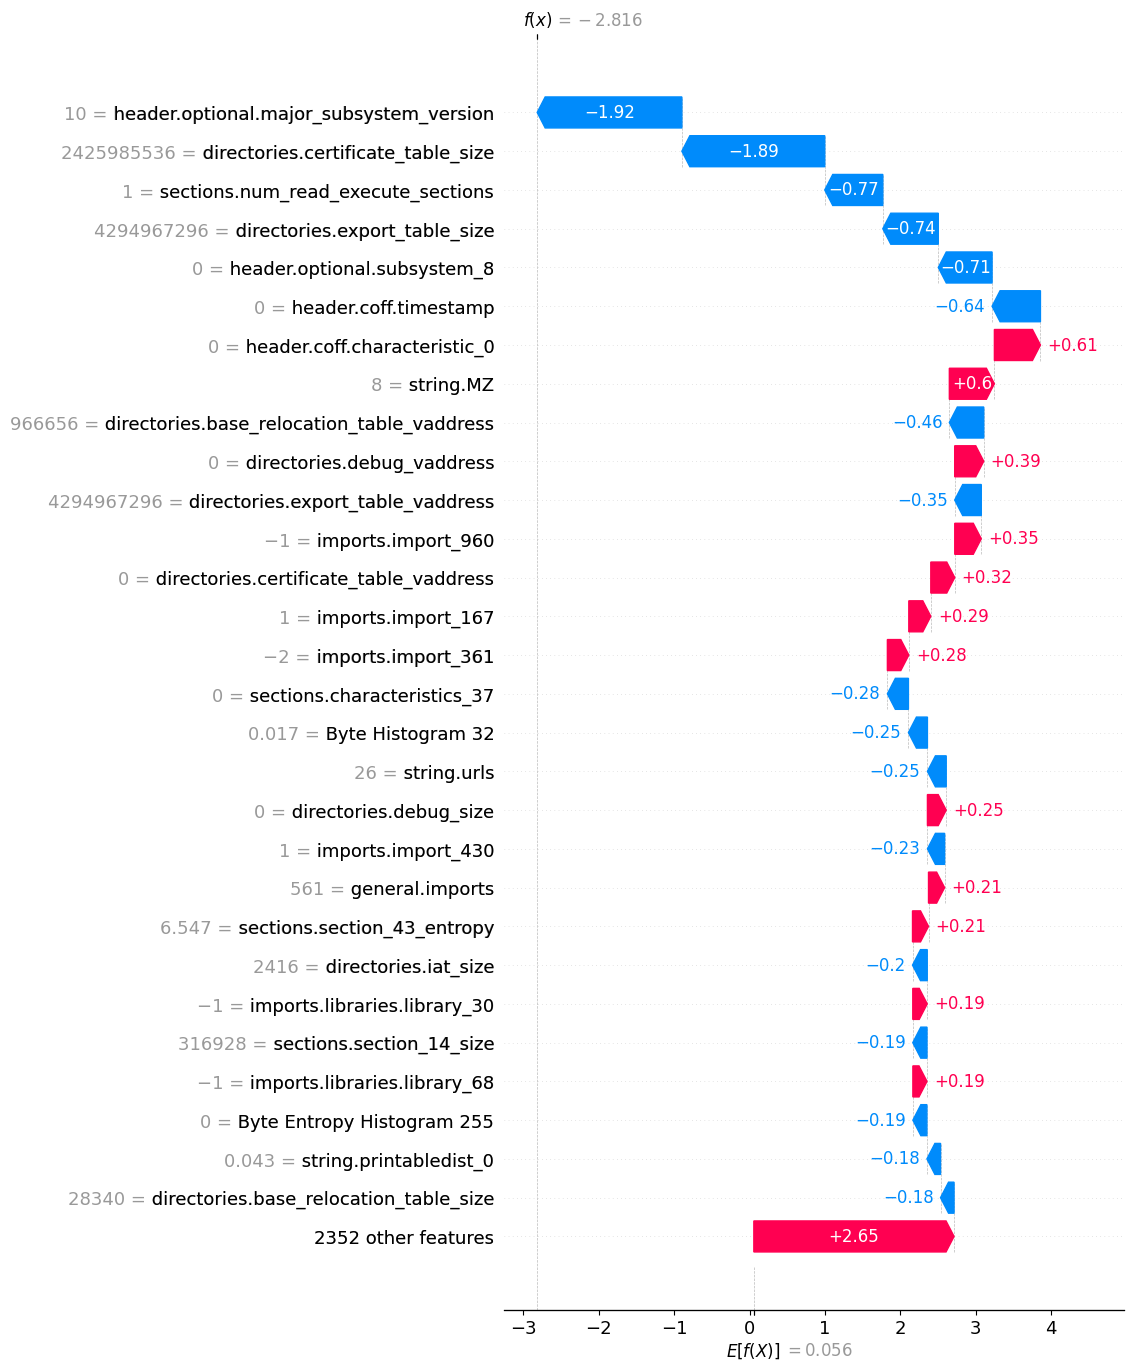

In [10]:
shap.plots.waterfall(shap_values_single[0], max_display=30)

In [11]:
# shap_values = explainer(pd.DataFrame(X_train[:4000]))
# shap.summary_plot(shap_values,feature_names=feature_names,max_display=30)

In [12]:
# import json
# filename = "file.json"
# with open(f'/workspaces/torment-nexus/temp/{filename}', 'r') as file:
#     raw_features = json.load(file)

In [13]:
raw_features["datadirectories"]

[{'name': 'lief._lief.PE.TYPES.EXPORT_TABLE',
  'size': 4294967295,
  'virtual_address': 4294967295},
 {'name': 'lief._lief.PE.TYPES.IMPORT_TABLE',
  'size': 580,
  'virtual_address': 912884},
 {'name': 'lief._lief.PE.TYPES.RESOURCE_TABLE',
  'size': 16384,
  'virtual_address': 1015808},
 {'name': 'lief._lief.PE.TYPES.EXCEPTION_TABLE',
  'size': 0,
  'virtual_address': 0},
 {'name': 'lief._lief.PE.TYPES.CERTIFICATE_TABLE',
  'size': 2425985433,
  'virtual_address': 0},
 {'name': 'lief._lief.PE.TYPES.BASE_RELOCATION_TABLE',
  'size': 28340,
  'virtual_address': 966656},
 {'name': 'lief._lief.PE.TYPES.DEBUG', 'size': 0, 'virtual_address': 0},
 {'name': 'lief._lief.PE.TYPES.ARCHITECTURE', 'size': 0, 'virtual_address': 0},
 {'name': 'lief._lief.PE.TYPES.GLOBAL_PTR', 'size': 0, 'virtual_address': 0},
 {'name': 'lief._lief.PE.TYPES.TLS_TABLE', 'size': 0, 'virtual_address': 0},
 {'name': 'lief._lief.PE.TYPES.LOAD_CONFIG_TABLE',
  'size': 0,
  'virtual_address': 0},
 {'name': 'lief._lief.PE.TY

In [14]:
df = pd.DataFrame(X_train[:300])
df.columns = feature_names

In [15]:
df

,Byte Histogram 0,Byte Histogram 1,Byte Histogram 2,Byte Histogram 3,Byte Histogram 4,Byte Histogram 5,Byte Histogram 6,Byte Histogram 7,Byte Histogram 8,Byte Histogram 9,...,directories.load_config_table_size,directories.load_config_table_vaddress,directories.bound_import_size,directories.bound_import_vaddress,directories.iat_size,directories.iat_vaddress,directories.delay_import_descriptor_size,directories.delay_import_descriptor_vaddress,directories.clr_runtime_header_size,directories.clr_runtime_header_vaddress
0,0.014676,0.004222,0.003923,0.004029,0.004007,0.003775,0.003825,0.003887,0.004153,0.003804,...,72.0,35240.0,0.0,0.0,660.0,32768.0,0.0,0.0,0.0,0.0
1,0.184524,0.031308,0.005693,0.005959,0.008144,0.003512,0.005786,0.008550,0.009141,0.001791,...,64.0,92936.0,408.0,608.0,2604.0,4096.0,224.0,442296.0,0.0,0.0
2,0.251737,0.014205,0.006841,0.008556,0.023493,0.002858,0.003401,0.008556,0.010215,0.001176,...,0.0,0.0,0.0,0.0,1120.0,4096.0,192.0,37280.0,0.0,0.0
3,0.008964,0.004055,0.003925,0.003936,0.004037,0.003878,0.003847,0.003946,0.003939,0.003834,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.020401,0.005213,0.004519,0.004097,0.004240,0.004029,0.003785,0.004593,0.004875,0.003780,...,0.0,0.0,0.0,0.0,520.0,4096.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.509766,0.009208,0.003348,0.001395,0.006696,0.000279,0.073382,0.000000,0.002790,0.000558,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
296,0.332053,0.009578,0.005248,0.006991,0.007572,0.003749,0.004311,0.004330,0.020805,0.007385,...,0.0,0.0,0.0,0.0,156.0,32768.0,0.0,0.0,0.0,0.0
297,0.459196,0.005111,0.005632,0.001530,0.006429,0.001969,0.002572,0.000798,0.005794,0.000944,...,64.0,32912.0,0.0,0.0,452.0,28672.0,0.0,0.0,0.0,0.0
298,0.400236,0.010100,0.005153,0.004459,0.006836,0.001953,0.002159,0.002583,0.006592,0.001709,...,64.0,37400.0,0.0,0.0,244.0,32768.0,0.0,0.0,0.0,0.0
